Import the necessary python packages and libraries in the following cell.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import torchvision.models as models
from torchvision import datasets
import seaborn as sns
import matplotlib.pyplot as plt

Print the torch and torchvision version

In [2]:
# Your code here
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

PyTorch version: 2.3.0+cu121
Torchvision version: 0.18.0+cu121


Set the device to cuda, if available.

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Transform or preprocess the data:

*   Normalize data
*   Resize each image to 224 x 224
*   Add Color Jitter with hue and saturation as 0.5
*   Introduce Random horizontal flips
*   Rotate images about 20 degrees


In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(hue=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

Train and test Resnet18 on Even numbered Classes in CIFAR10 Dataset.


In [6]:
class CustomCIFAR10(datasets.CIFAR10):
    def __init__(self, *args, label_mapping=None, valid_classes=None, **kwargs):
        super(CustomCIFAR10, self).__init__(*args, **kwargs)
        self.label_mapping = label_mapping
        self.valid_classes = valid_classes

    def __getitem__(self, index):
        img, target = super(CustomCIFAR10, self).__getitem__(index)
        if self.valid_classes is not None and target not in self.valid_classes:
            raise KeyError(f"Class {target} not in valid_classes.")
        if self.label_mapping is not None:
            target = self.label_mapping.get(target, target)
        return img, target

    def __len__(self):
        return super(CustomCIFAR10, self).__len__()

label_mapping = {0: 0, 2: 1, 4: 2, 6: 3, 8: 4}
even_classes = [0, 2, 4, 6, 8]

# Ensure valid_classes cover all classes present in the dataset
valid_classes = set(range(10))

trainset = CustomCIFAR10(root='./data', train=True, download=True, transform=transform, label_mapping=label_mapping, valid_classes=valid_classes)
testset = CustomCIFAR10(root='./data', train=False, download=True, transform=transform, label_mapping=label_mapping, valid_classes=valid_classes)

train_subset_indices = [i for i in range(len(trainset)) if trainset[i][1] in even_classes]
test_subset_indices = [i for i in range(len(testset)) if testset[i][1] in even_classes]

train_subset = Subset(trainset, train_subset_indices)
test_subset = Subset(testset, test_subset_indices)

trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
trainloader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
testloader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

In [8]:
model = models.resnet18(pretrained=True)

model.fc = nn.Linear(model.fc.in_features, len(even_classes)).to(device)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Train

In [10]:
def train(model, trainloader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        _, pred = outputs.max(1)
        total_train += labels.size(0)
        correct_train += pred.eq(labels).sum().item()

    train_acc = 100 * correct_train / total_train
    return train_loss / len(trainloader), train_acc

Test

In [11]:
def test(model, testloader, criterion, device):
    model.eval()
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate accuracy
            _, pred = outputs.max(1)
            total_test += labels.size(0)
            correct_test += pred.eq(labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    return test_accuracy

Plot the accuracy achieved:

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [13]:
def plot_accuracies(train_accuracies, test_accuracies, epochs):
    print("Train Accuracies:", train_accuracies)
    print("Test Accuracies:", test_accuracies)

    plt.plot(range(1, epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracies vs Epochs')
    plt.legend()
    plt.show()

Confusion Matrix from scratch

In [14]:
def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_labels = []
    all_predictions = []

    num_classes = len(class_names)
    confusion_matrix = torch.zeros(num_classes, num_classes)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Get predicted labels
            _, preds = torch.max(outputs, 1)

            # Update confusion matrix
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1


    plt.figure(figsize=(num_classes, num_classes))
    sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

Main function

In [15]:
epochs = 5
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    train_loss, train_acc = train(model, trainloader, criterion, optimizer, device)
    test_acc = test(model, testloader, criterion, device)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f'Epoch {epoch + 1} | Train Loss: {train_loss:.3f} | Train Accuracy: {train_acc:.3f}% | Test Accuracy: {test_acc:.3f}%')

Epoch 1 | Train Loss: 0.360 | Train Accuracy: 86.067% | Test Accuracy: 84.700%
Epoch 2 | Train Loss: 0.224 | Train Accuracy: 91.647% | Test Accuracy: 92.800%
Epoch 3 | Train Loss: 0.184 | Train Accuracy: 93.267% | Test Accuracy: 93.067%
Epoch 4 | Train Loss: 0.172 | Train Accuracy: 93.860% | Test Accuracy: 93.033%
Epoch 5 | Train Loss: 0.137 | Train Accuracy: 94.807% | Test Accuracy: 95.000%


Train Accuracies: [86.06666666666666, 91.64666666666666, 93.26666666666667, 93.86, 94.80666666666667]
Test Accuracies: [84.7, 92.8, 93.06666666666666, 93.03333333333333, 95.0]


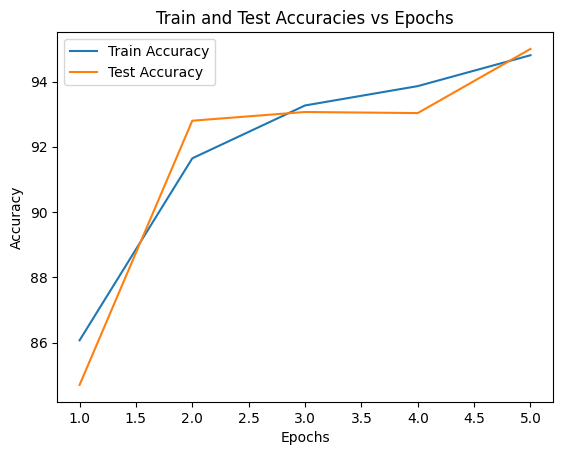

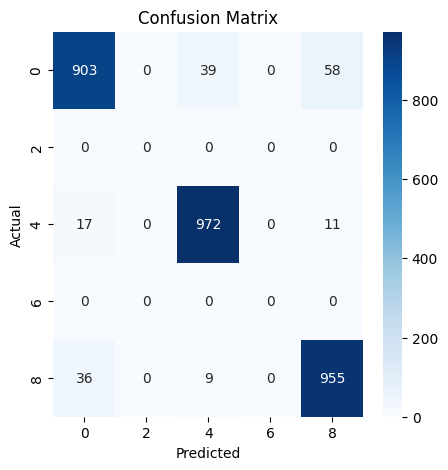

In [16]:
plot_accuracies(train_accuracies, test_accuracies, epochs)
class_names = ['0', '2', '4', '6', '8']
plot_confusion_matrix(model, testloader, class_names, device)